# Hierarchical bayesian modeling
This approach models both group and individual responses. Individual variation is modeled but it is assumed to be orderly distributed. The distribution, distributed acrss individuals is referred to as the **parent distribution**, which determines the priors for each individual. This distribution is sometimes referred to as the **hyperprior distribution**.

This approach can be carried out with any cognitive model.

### Graphical models
Graphical models are a helpful way to picture bayesian hierarchical models. An example is given for the signal detection model of all participants data in the previous chapter.
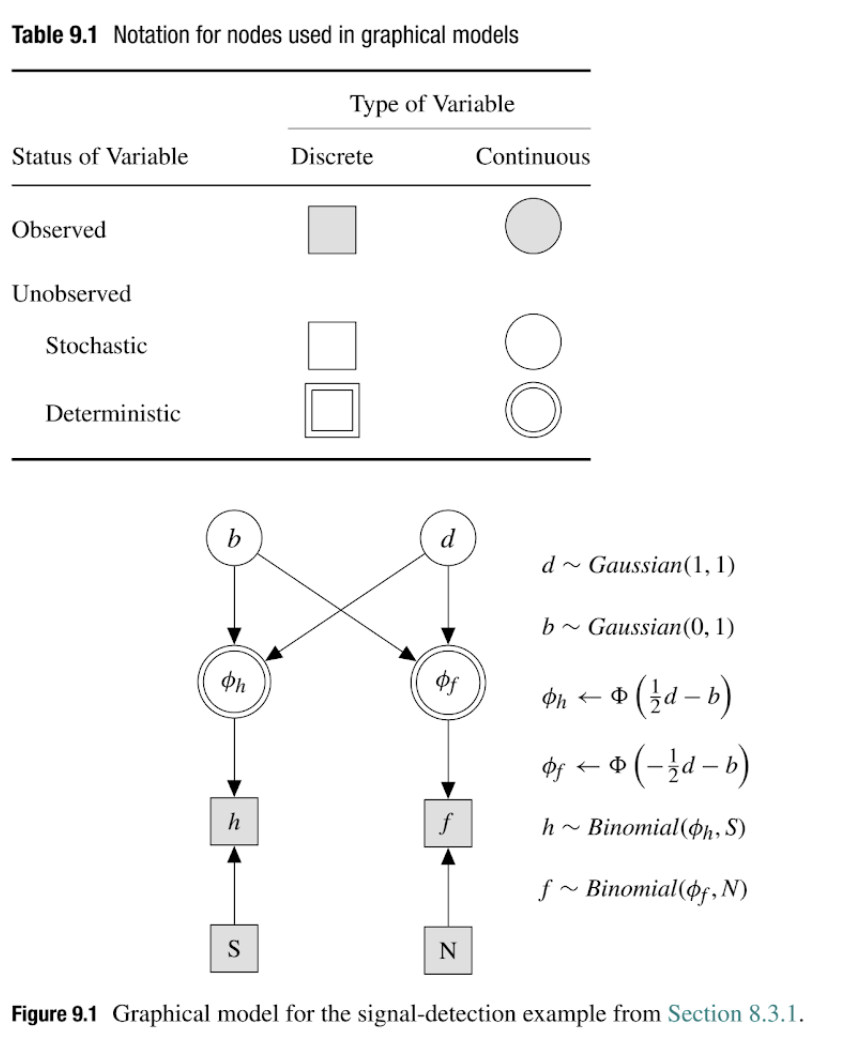
$\phi f$ and $\phi h$ are determined by $b$ and $d$. This is all the same as before.
<br>
### Hierarchical Signal Detection Theory
Now, we apply a hierarchical model for the signal detection model we used in the previous chapter.
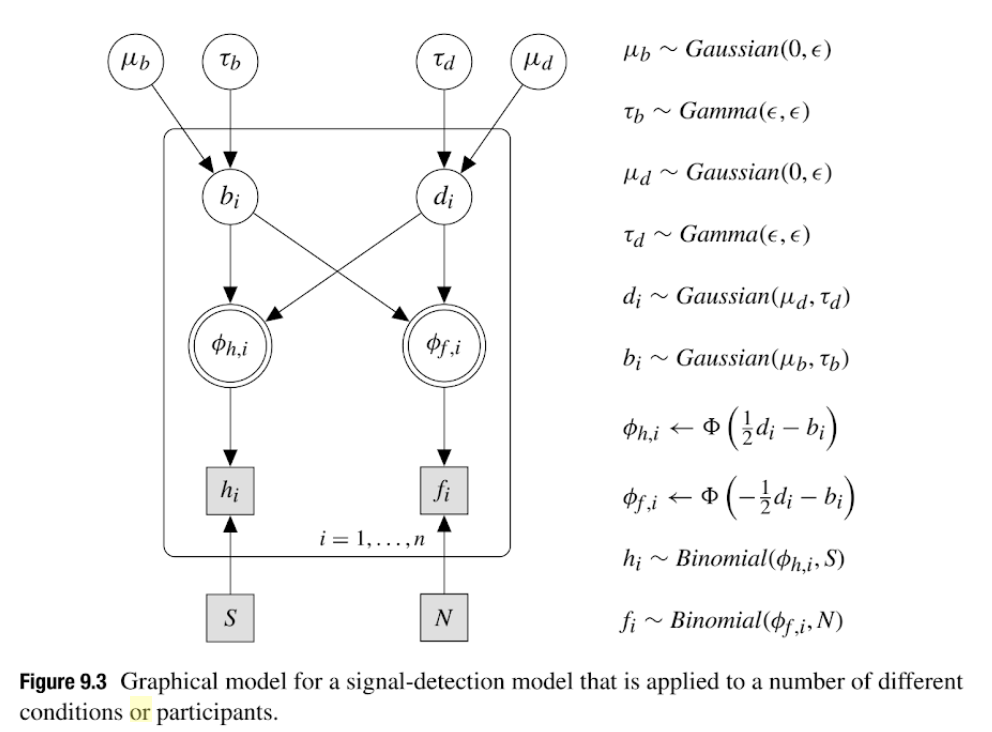
<br>

### Lets go to the code...
<br>
below is the .j file for jags
```
#hierarchical signal detection theory
model{
    # parent ditributions for priors
    mud ~ dnorm(0,epsilon)
    mub ~ dnorm(0,epsilon)
    taud ~ dgamma(epsilon,epsilon)
    taub ~ dgamma(epsilon,epsilon)
    
    # modeling all n subjects
    for (i in 1:n) {
        # priors for discriminability and bias
        d[i] ~ dnorm(mud,taud)
        b[i] ~ dnorm(mub,taub)
        
        # predictions for hits and false alarms
        phih[i] <- phi( d[i]/2 - b[i] )
        phif[i] <- phi(-d[i]/2 - b[i] )
        
        # observed hits and false alarms
        h[i] ~ dbin(phih[i],sigtrials)
        f[i] ~ dbin(phih[i],noistrials)
    }
}
```

In [4]:
library(rjags)
# simulate data from experiment with 10 subject
n<-10
sigtrials<-noistrials<-100
h<-rbinom(n,sigtrials, 0.8)
f<-rbinom(n,sigtrials, 0.2)

#initialize for JAGS
oneint<-list( mud=0, mub=0, taud=1, taub=1, d=rep(0,n), b=rep(0,n) )


myints <- list(oneint)[rep(1,4)]
sdtjh <- jags.model("hsdt.j", 
                    data=list("epsilon"=0.001,
                              "h"=h, "f"=f, "n"=n,
                              "sigtrials"=sigtrials,
                              "noistrials"=noistrials), 
                    inits=myints,
                    n.chains=4)

# burnin
update(sdtjh,n.iters=1000)

# perform MCMC
parameters <- c( "d","b","taud","taub","mud","mub","phih","phif" )
mcmcfin <- coda.samples(sdtjh, parameters, 5000)

Loading required package: coda
Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 20
   Unobserved stochastic nodes: 24
   Total graph size: 120

Initializing model



In [ ]:
summary(mcmcfin)
plot(mcmcfin)

### observed vs. predicted and Stein's paradox
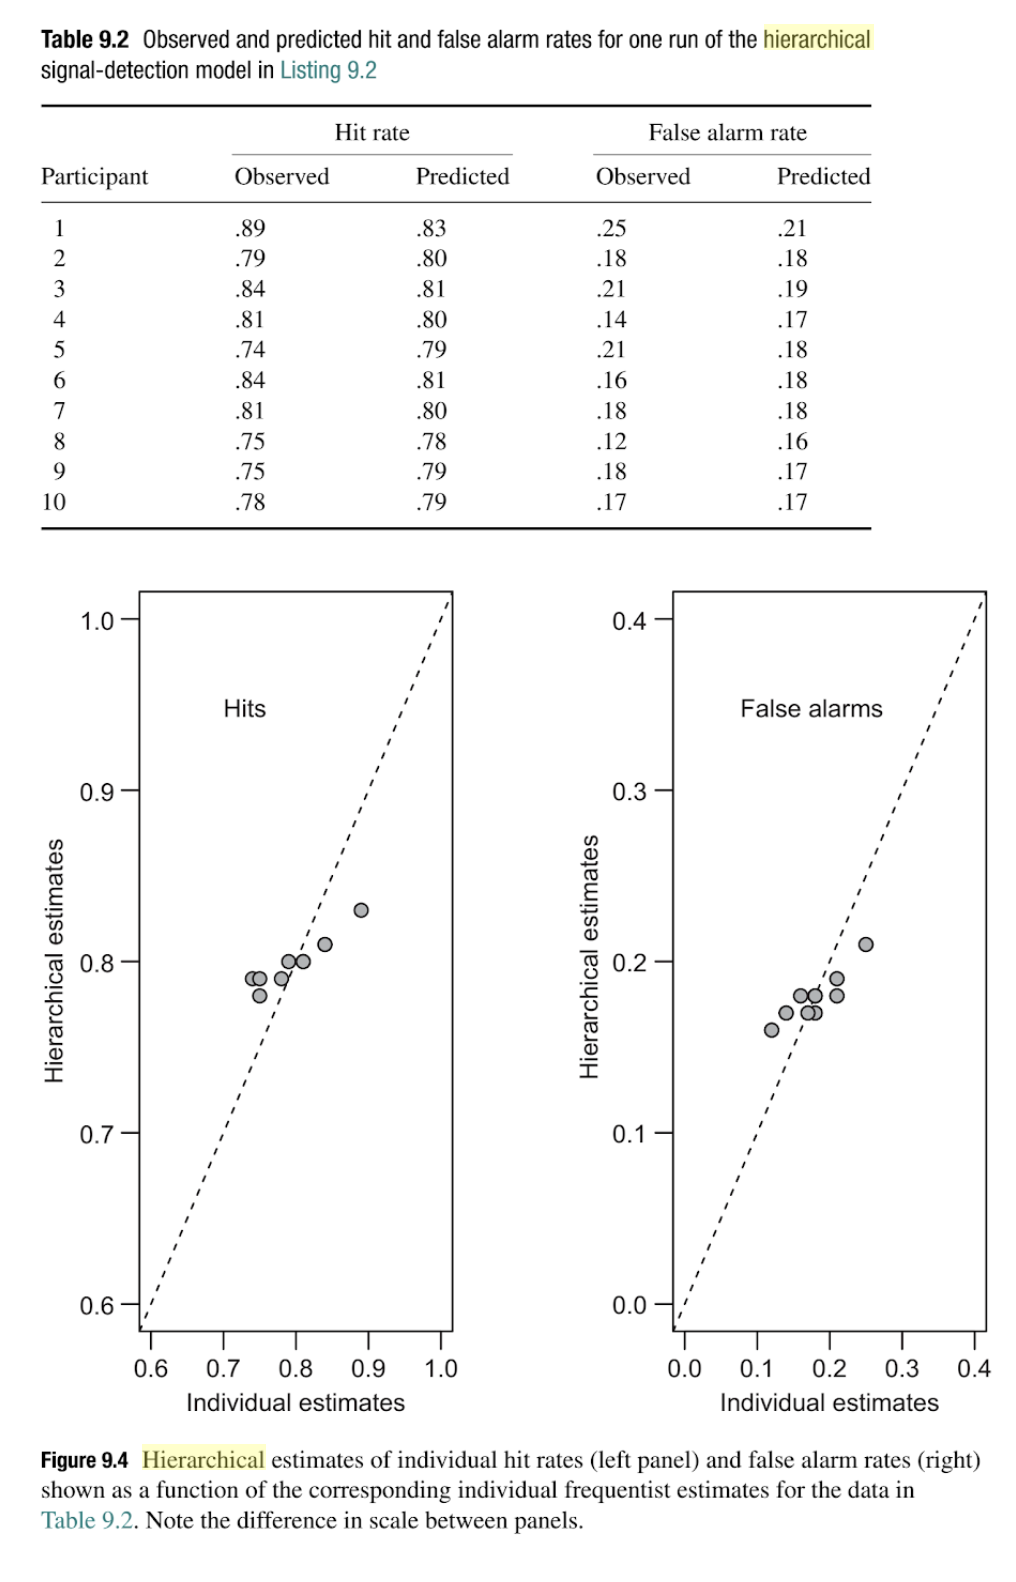

Stein's paradox does in fact fit a better model. Trust us.

Moving on.

### Hierarchical exponential forgetting model
Forgetting is exponential vs. forgetting is a power function:
$$ \theta_t = a+(1-a)*b*e^{-\alpha*t}$$

$$ \theta_t = a+(1-a)*b*(1+t)^{-\beta}$$

$a$ is an asymptote, >0 that represents a minimum amount of memory after infinite time.
$b$ is <1, and represents poor encoding or loss of information before time interval.

We assume participants will perform differently.

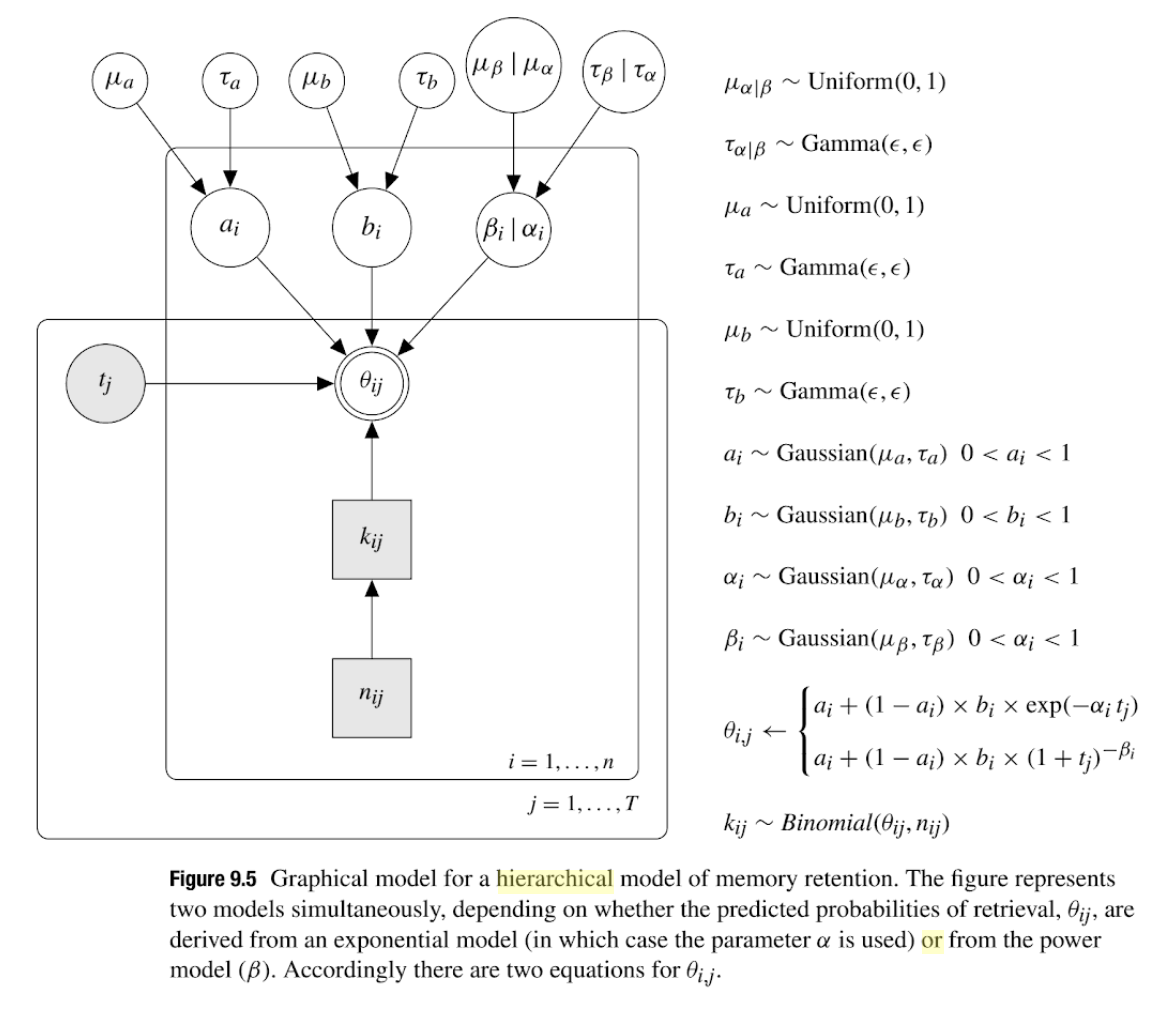


Hierarchical forgetting model .j jags file
```
# hierarchical exponential forgetting model
model {

    # Priors for parent Distributions
    mualpha ˜ dunif (0 ,1)
    taualpha ˜ dgamma (epsilon , epsilon)
    mua ˜ dunif (0 ,1)
    taua ˜ dgamma (epsilon , epsilon)
    mub ˜ dunif (0 ,1)
    taub ˜ dgamma (epsilon , epsilon)

    # individual sampled parameters
    for (i in 1 :ns) {
    alpha[i] ˜ dnorm (mualpha , taualpha)T(0 ,1)
    a[i] ˜ dnorm (mua , taua)T(0 ,1)
    b[i] ˜ dnorm (mub , taub)T(0 ,1)
    }
    
    # predictions for each subject at each lag
    for (i in 1 :ns) {
        for (j in 1 :nt) {
            theta[i , j] <− a[i]+(1−a[i ] ) ∗b[i] ∗exp(−alpha[i] ∗ t [j ] )
        }
    }

    # observed data
    for (i in 1 :ns) {
        for (j in 1 :nt) {
            k[i , j] ˜ dbin(theta[i , j ] , n)
        }
    }
}
```

In [8]:
library (rjags)
epsilon <- .001

#simulate data for 4 subjects
tlags <- c(0 , 1, 5, 10, 20, 50)
nlags <- length(tlags)
nsubj <- 4
nitems <- 20
nrecalled <- matrix(0 ,nsubj, nlags)
for (i in c (1:nsubj) ) {
    a <- runif(1 ,.0 ,.2)
    b <- runif(1 ,.9 ,1.0)
    alpha <- runif(1 ,.1 ,.4)
    print ( c (a , b , alpha) )
    for (j in c (1:nlags)){
        p <- a + (1-a) * b * exp(-alpha*tlags[j ] )
        nrecalled[i,j] <- rbinom(1 ,nitems , p)
    }
}

# define model
forgexpjh<-jags.model("hef.j",
                     data=list(
                         "epsilon"=epsilon,
                         "t"=tlags,
                         "k"=nrecalled,
                         "n"=nitems,
                         "ns"=nsubj ,
                         "nt"=nlags), 
                     n.chains=1)

# burnin
update(forgexpjh,n.iter=1000)

# perform MCMC
parameters<-c("mualpha","mua","mub","taualpha","taua","taub","a","b","alpha","theta")
mcmcfin<-coda.samples(forgexpjh,parameters,5000)

[1] 0.03376012 0.95391201 0.33265968
[1] 0.1441007 0.9383543 0.1996916
[1] 0.1651980 0.9556797 0.1757242
[1] 0.1873648 0.9330622 0.1266892
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 24
   Unobserved stochastic nodes: 18
   Total graph size: 159

Initializing model




Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                Mean        SD  Naive SE Time-series SE
a[1]       1.089e-01 3.331e-02 4.711e-04      6.536e-04
a[2]       2.304e-01 4.655e-02 6.583e-04      1.333e-03
a[3]       8.344e-02 4.254e-02 6.016e-04      1.045e-03
a[4]       7.903e-02 3.360e-02 4.752e-04      6.703e-04
alpha[1]   3.560e+00 7.138e-02 1.010e-03      1.530e-02
alpha[2]   1.683e+01 4.315e-01 6.102e-03      1.482e-01
alpha[3]   4.581e-01 1.968e-01 2.783e-03      5.522e-03
alpha[4]   1.731e+01 3.840e-01 5.430e-03      1.101e-01
b[1]       2.324e+07 5.131e+06 7.256e+04      3.682e+06
b[2]       1.285e+07 3.953e+06 5.590e+04      3.225e+06
b[3]       8.138e-01 6.775e-02 9.582e-04      1.439e-03
b[4]       1.761e+07 4.267e+06 6.034e+04      2.921e+06
mua        1.310e-01 5.903e-02 8.348e-04      1.532e-03
mualpha    5.196e-0

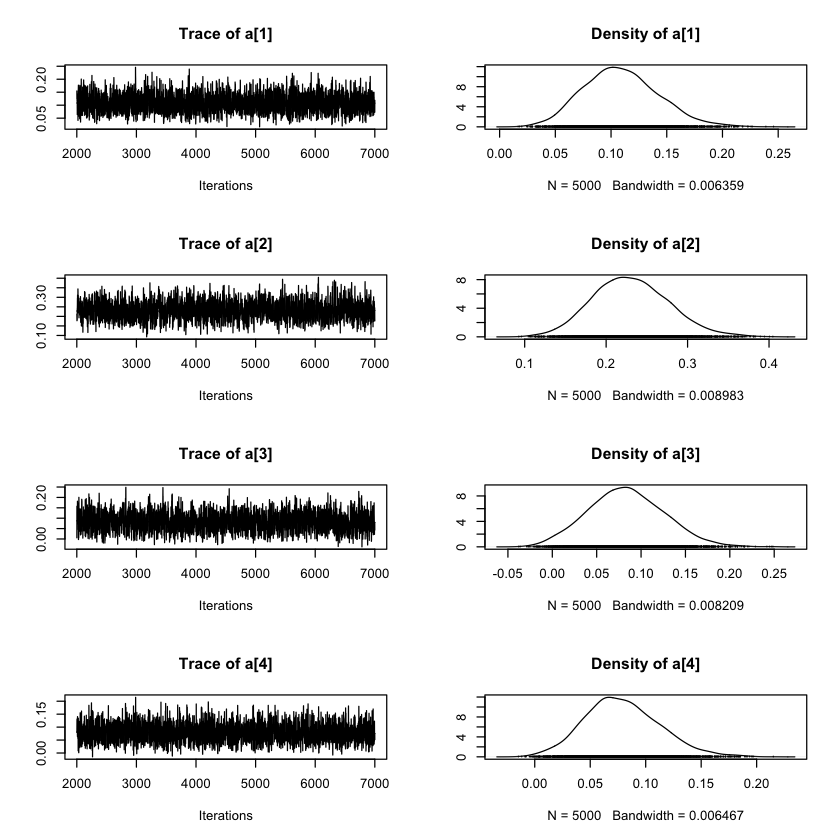

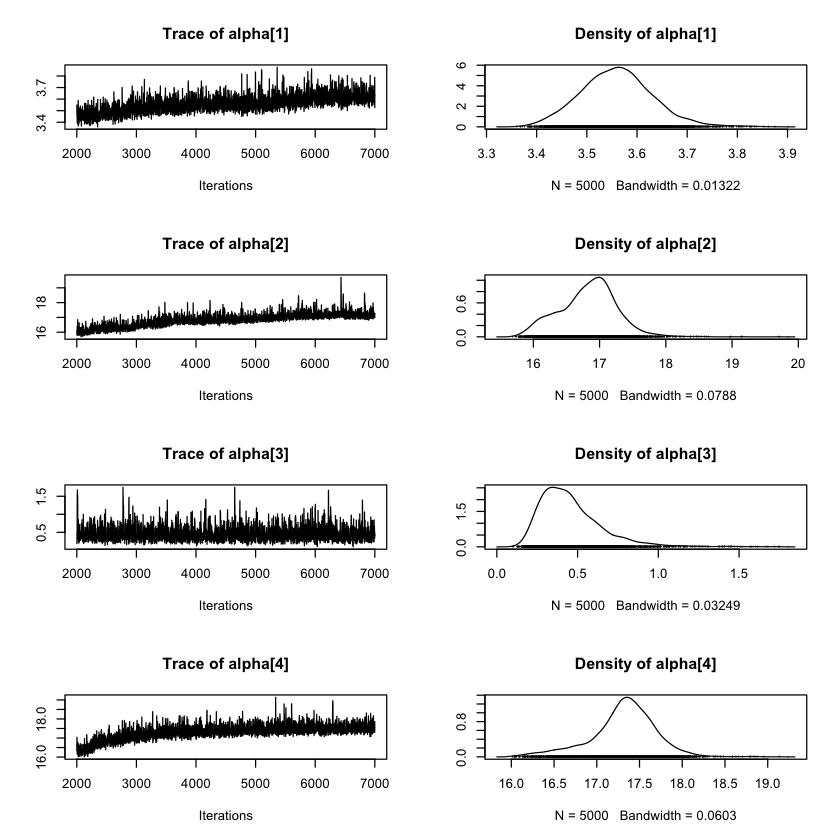

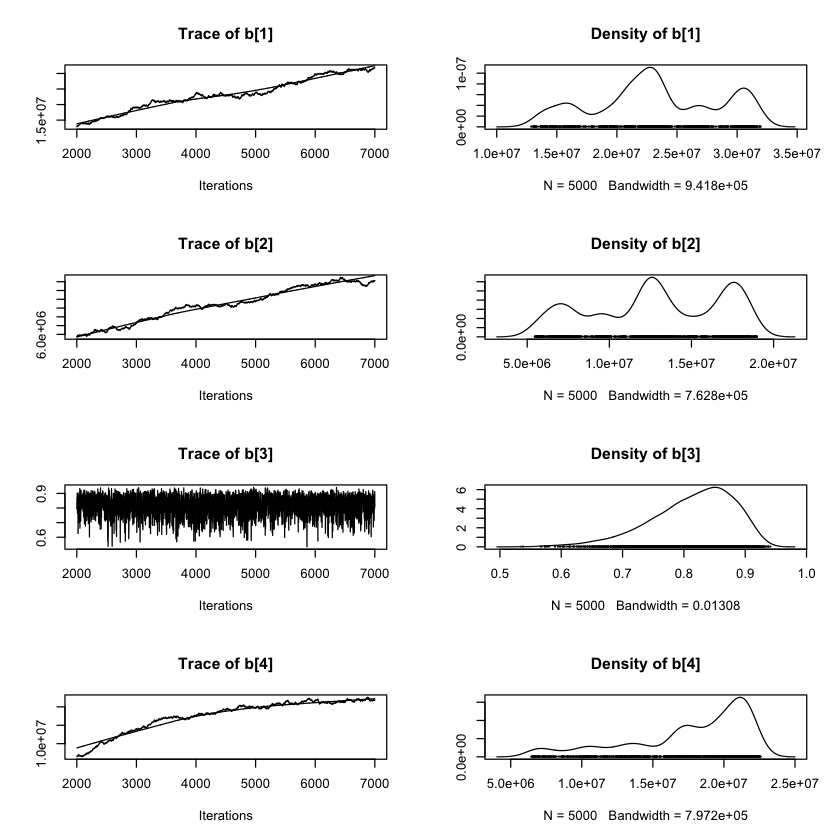

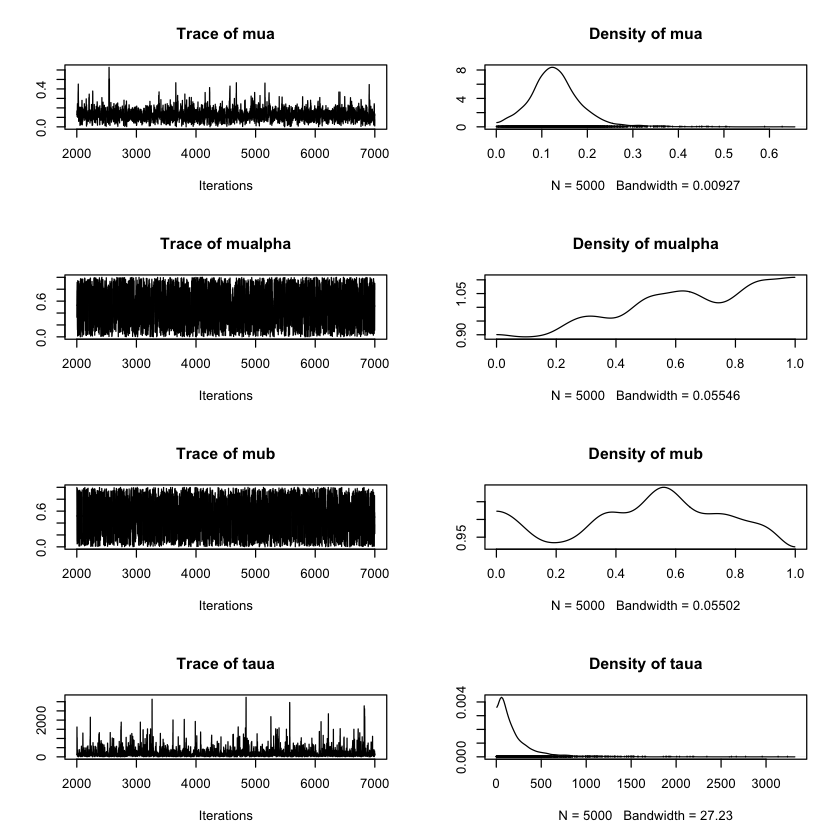

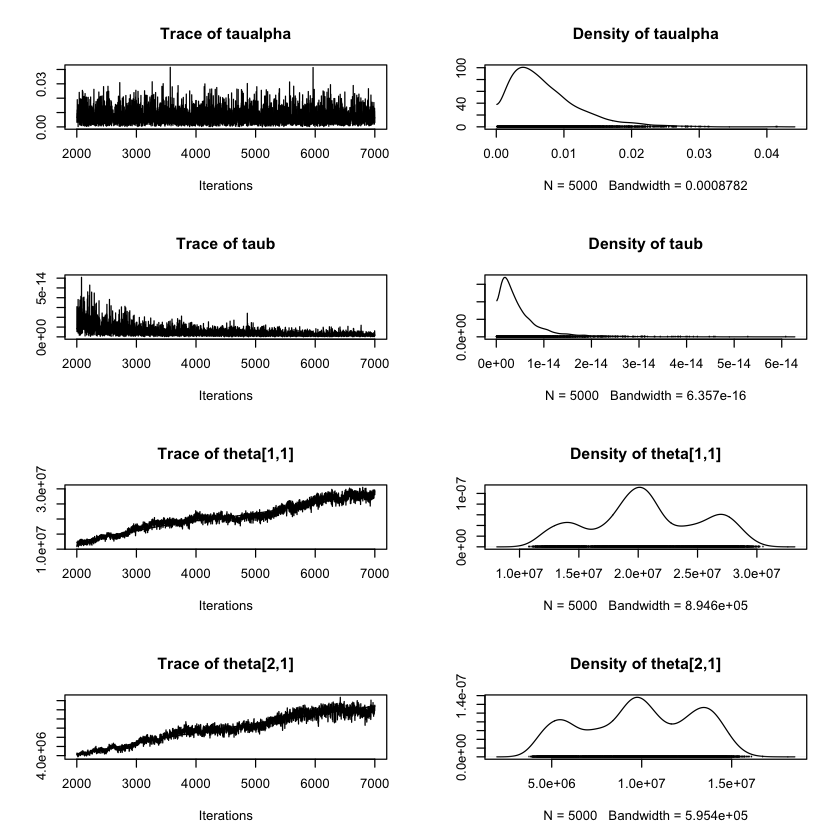

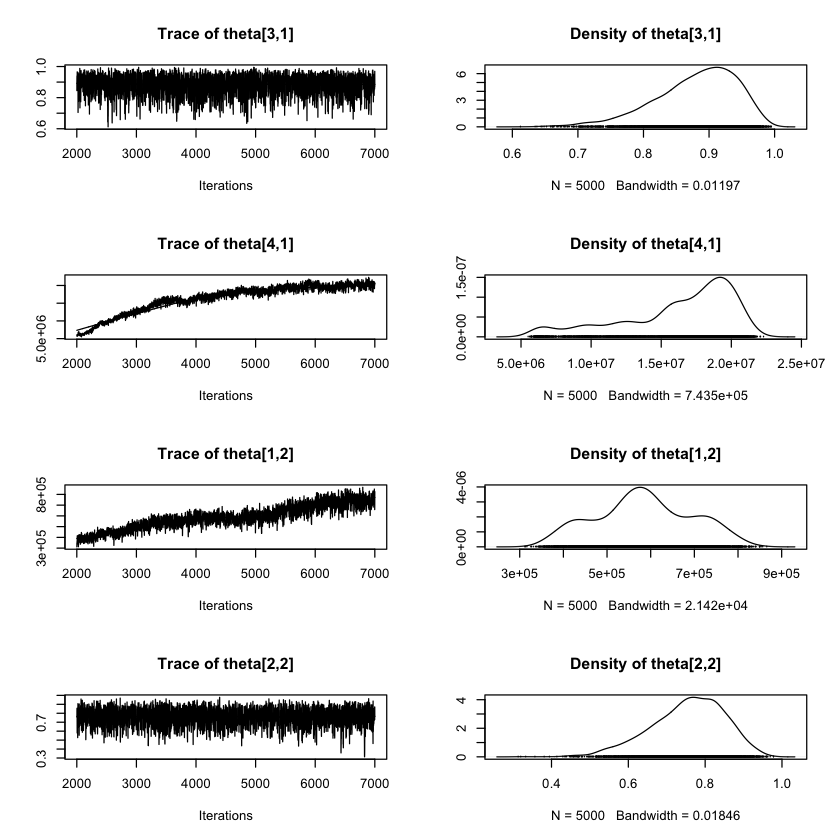

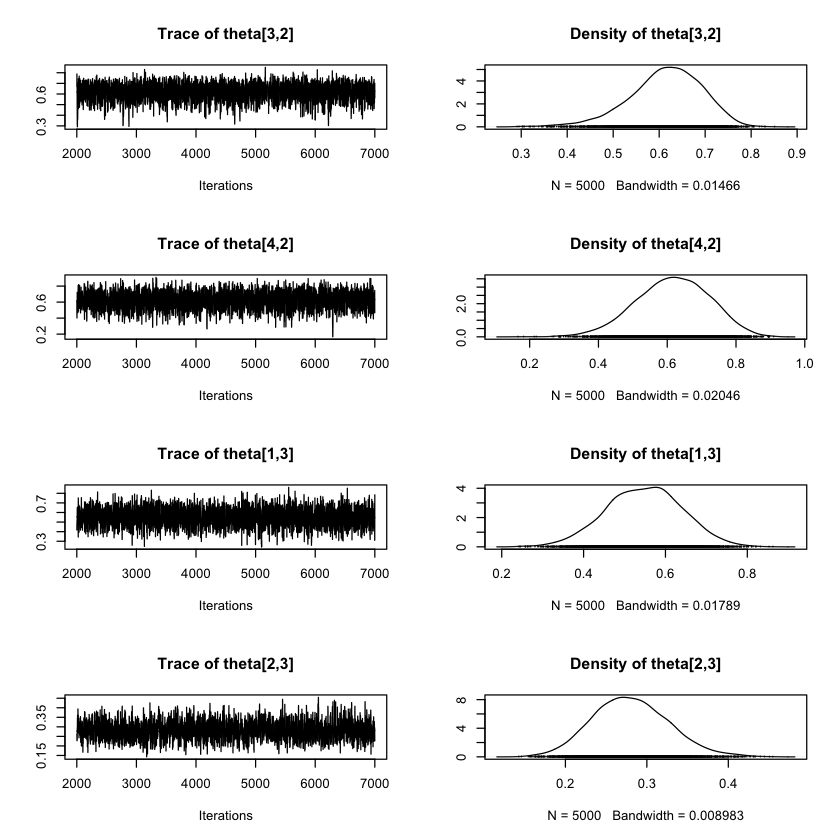

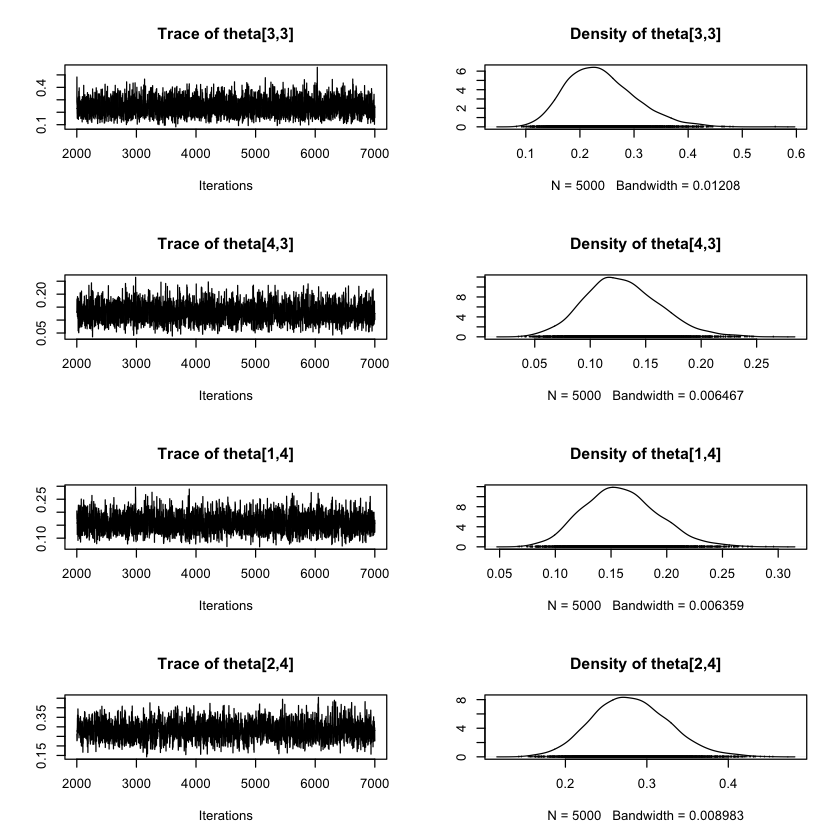

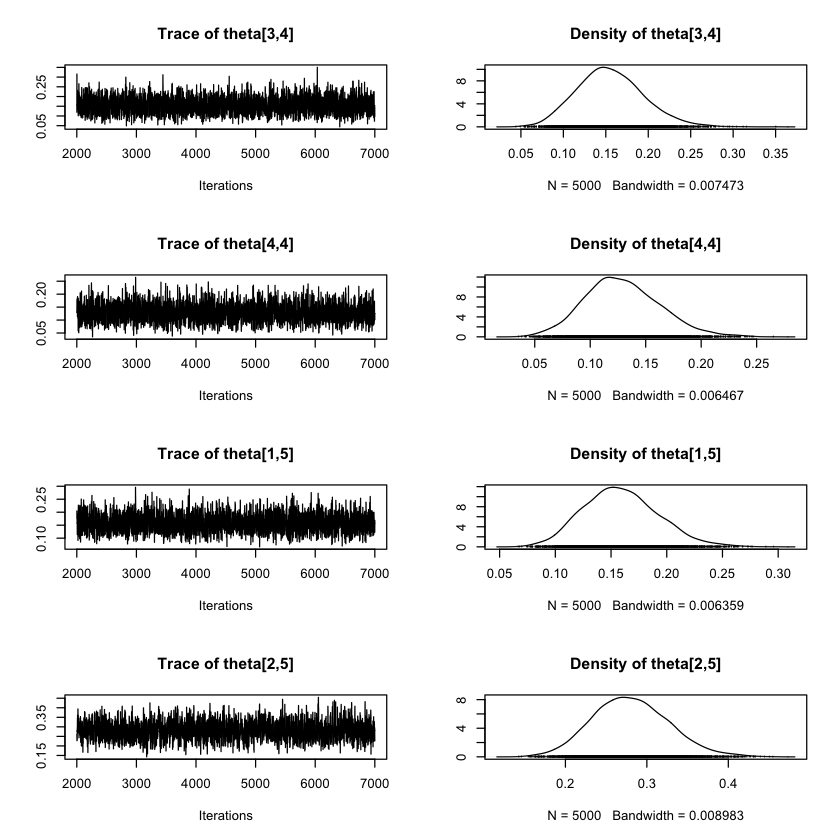

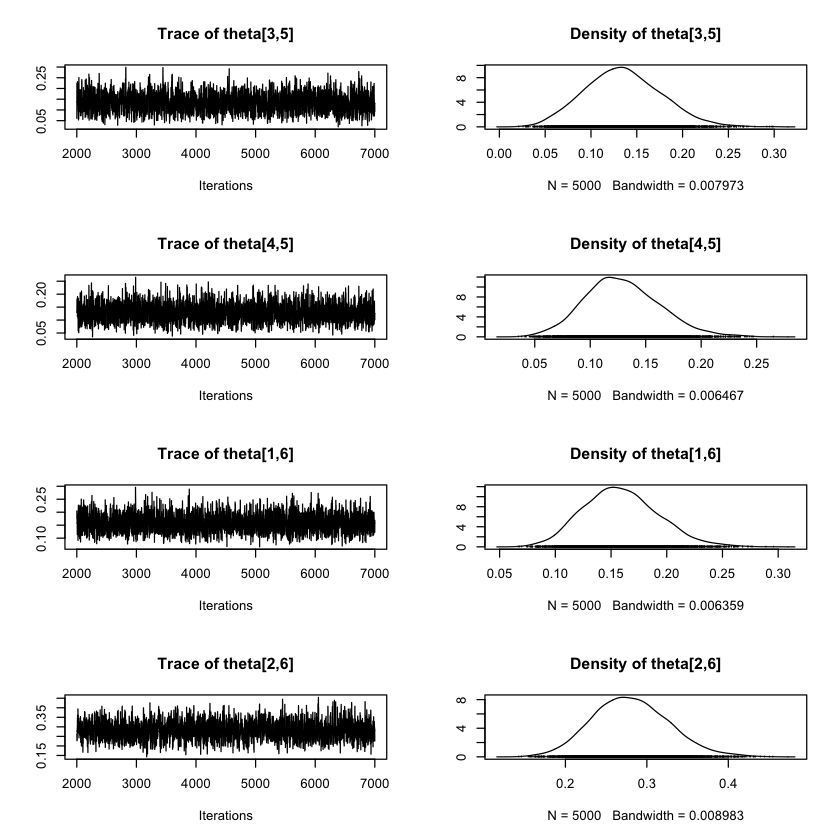

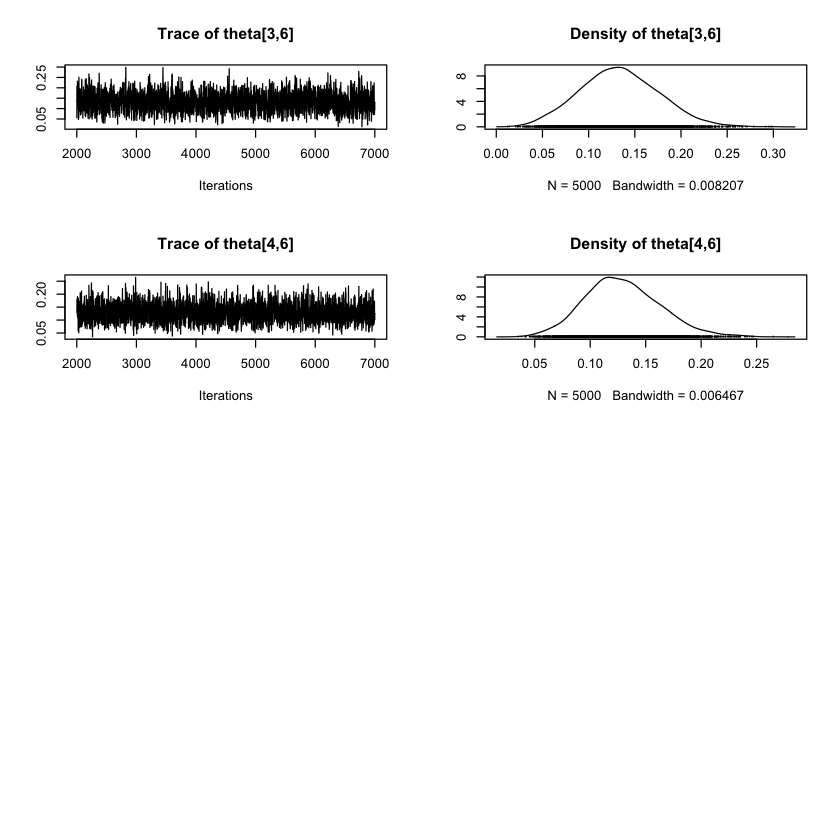

In [5]:
summary(mcmcfin)
plot(mcmcfin)

#### Results
theta distribution = posterior predictive distribution, take the mean to get our 'best' parameter estimate.

plotted is the posterior densities of the three parameters for each subject separately
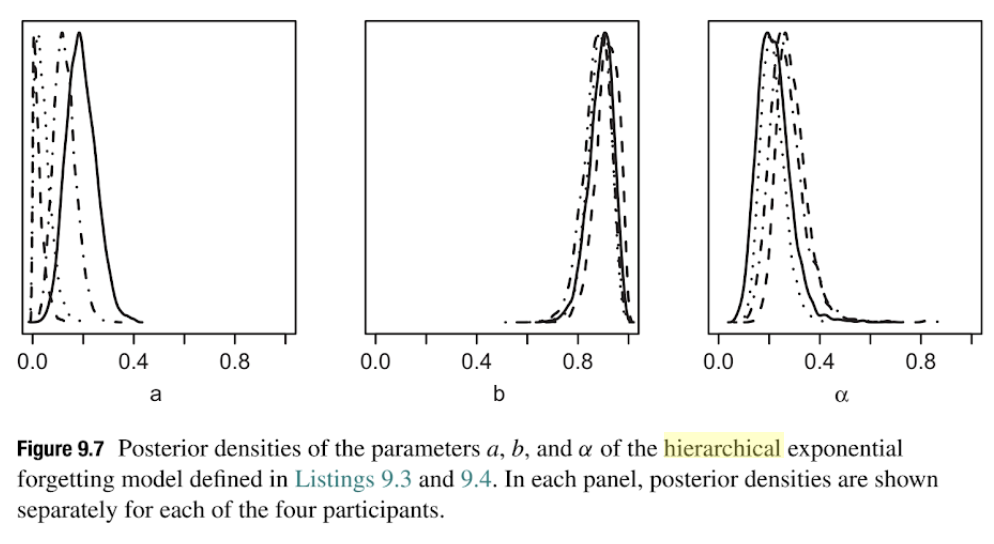

#### The main point here is that the hierarchical model approximates a simulated participants true behavior.

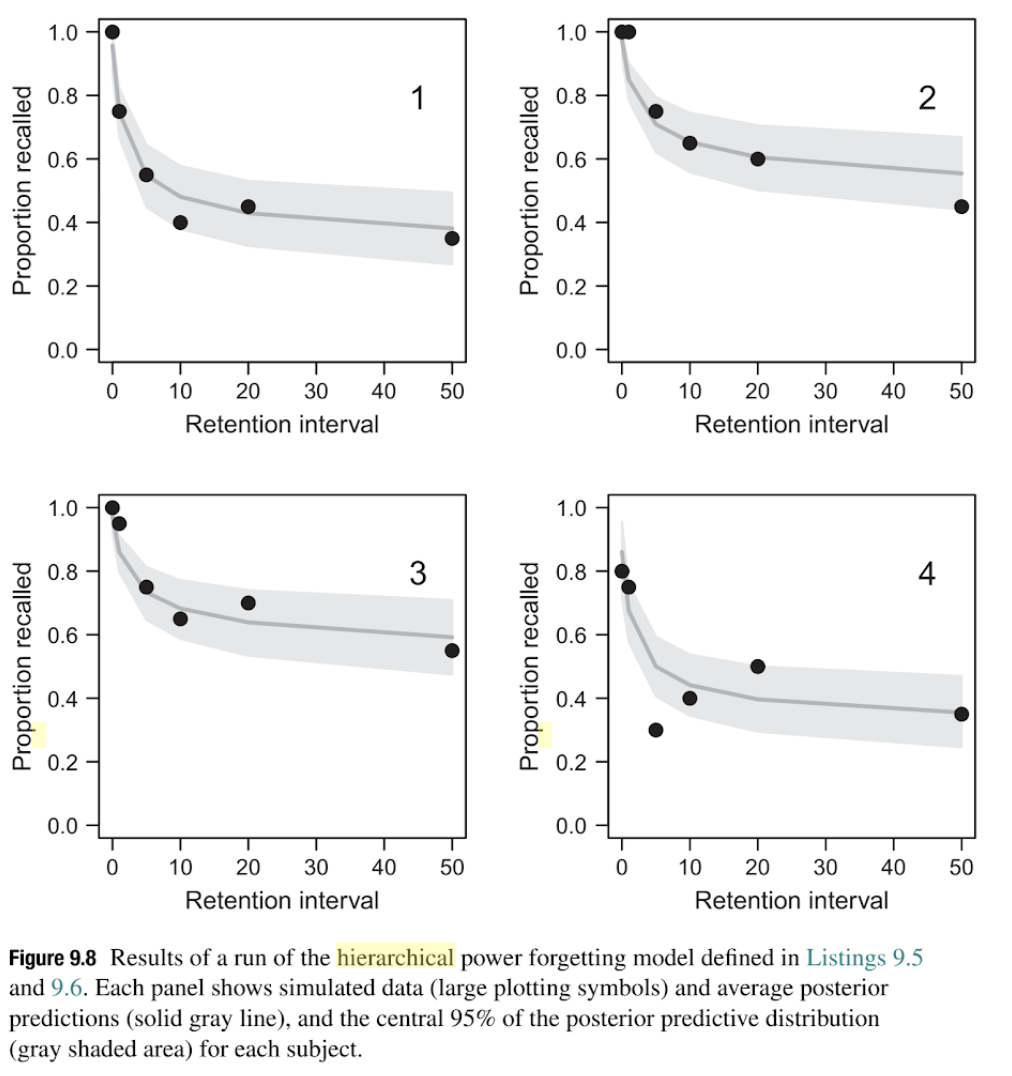

### Now we compare with power function

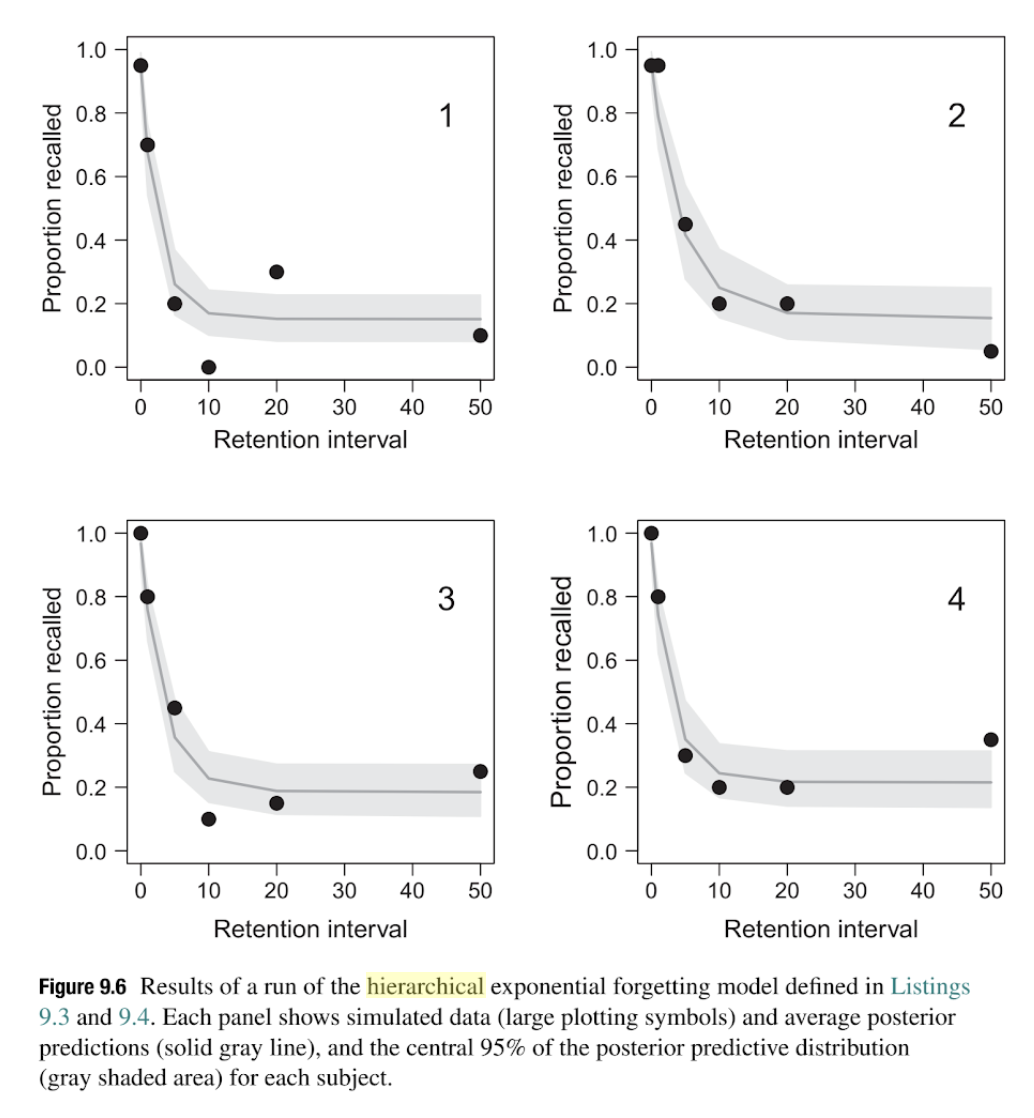



<img src="attachment:Screenshot%202018-04-09%2015.22.28.png" style="width: 500px" >



In [17]:
library (rjags)
epsilon <- .001

#simulate data for 4 subjects
tlags <- c(0 , 1, 5, 10, 20, 50)
nlags <- length(tlags)
nsubj <- 4
nitems <- 20
nrecalled <- matrix(0 ,nsubj, nlags)
for (i in c (1:nsubj) ) {
    a <- runif(1 ,.0 ,.2)
    b <- runif(1 ,.9 ,1.0)
    beta <- runif(1 ,.1 ,.4)
    print ( c (a , b , beta) )
    # predictions for each subject at each lag
    for (j in c(1:nlags)) {
        p <- a + (1-a) * b * (tlags[j]+1)^(-beta)
        nrecalled[i,j]<-rbinom(1,nitems,p)
    }
}

# define model
forgexpjh<-jags.model("hpf.j",
                     data=list(
                         "epsilon"=epsilon,
                         "t"=tlags,
                         "k"=nrecalled,
                         "n"=nitems,
                         "ns"=nsubj ,
                         "nt"=nlags), 
                     n.chains=1)

# burnin
update(forgexpjh,n.iter=1000)

# perform MCMC
parameters<-c("mualpha","mua","mub","taualpha","taua","taub","a","b","beta","theta")
mcmcfin<-coda.samples(forgexpjh,parameters,5000)

[1] 0.1211851 0.9181798 0.2710661
[1] 0.05777075 0.98308808 0.15916295
[1] 0.05660064 0.95910526 0.27840322
[1] 0.1763294 0.9411737 0.3455676
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 24
   Unobserved stochastic nodes: 18
   Total graph size: 140

Initializing model



## Hierarchical modeling of inter-temporal preferences

nope - data not available in readily accessible format... 

And, I Did not want to spend time making data....

In [ ]:
library (rjags)
kgrabfun<−function (x , p , var ) { return (x[x$subj==p , var ] ) }
itcdata<−read.table("hierarchicalITC.dat",header=TRUE) subjects <− unique (itcdata$subj)
ntrials <− dim (itcdata) [1] / length ( unique (itcdata$subj) )
nsubj <− length ( unique (itcdata$subj) )

delays4A <− t (vapply(subjects , FUN= function (x) grabfun(itcdata , x , ”DA” ) , integer (ntrials)))
delays4B <− t (vapply(subjects , FUN= function (x) grabfun(itcdata , x , ”DB” ) , integer (ntrials)))
amounts4A <− t (vapply(subjects , FUN= function (x) grabfun(itcdata , x , ”A” ) , integer (ntrials)))
amounts4B <− t (vapply(subjects , FUN= function (x) grabfun(itcdata , x , ”B” ) , integer (ntrials)))
responses <− t (vapply(subjects , FUN= function (x) grabfun(itcdata , x , ”R” ) , integer (ntrials)))

# initialize model for JAGS
hierITC <− jags . model ( ”hierarchicalITC . j” ,
data = list ( ”nsubj”=nsubj ,
              ”DA”=delays4A , ”DB”=delays4B ,
              ”A”=amounts4A , ”B”=amounts4B ,
              ”T”=ntrials , ”R”=responses) ,
n . chains=4)
# burnin
update (hierITC , n . iter=1000)

# perform MCMC
parameters <− c ( ”k” , ”alpha” , ”groupkmu” , ”groupksigma” , ”groupALPHAmu” , ”groupALPHAsigma” , ”VA” , ”VB” , ”P” , ”DB” )
mcmcfin<−coda . samples(hierITC , parameters,5000)

## Hierarchical Maximum Likelihood Modeling

The advantage of maximum-likelihood estimation is that it is computationally less expensive than Bayesian MCMC for problems in which the hierarchical likelihood function is fully tractable.

Several psychological models are isomorphic to a GLMM?

Going back to signal-detection, which can be implmeneted as a variants of relatively simple regression models.

To illustrate...

First, think of the signal and noise distributions in signal-detection theory as logistic, not gaussian. It looks similar with some different statistical properties.

INSERT MATH

$logit(P(r=1|X))=-c+d'X$, where $c$ is the criterion, $d'$ is the mean of the signal distribution, and $X$ is 1 or 0, coding the presence or absence of a signal.

$b$ = deviation from the optimal placement of the criterion at $d'/2$

$c$ = distance from the noise distribution

$b$ and $c$ refer to the same point and can be expressed as a function of one another; $b=c-d`/2$, but they are different parameters.


### Code

In [1]:
require(lme4)
n <- 10
sigtrials <- noistrials <- 100
ntrials <- sigtrials + noistrials
h <- rbinom (n , sigtrials , .60)
f <- rbinom (n , noistrials ,.11)

subj <- rep ( c (1: n) ,each=ntrials)
stim <- rep ( c ( rep (1 ,sigtrials) , rep (0 ,noistrials)),n)
resp <- as.vector(vapply(h,FUN= function (x)
    as.integer( c(rep (1,x), rep(0,ntrials-x))), integer(ntrials) ) + vapply(f, FUN=function (x) as.integer( c(rep (0,sigtrials), rep (1 ,x) , rep (0 , noistrials-x))),integer(ntrials) ) )

# model with intercept = z (FA) default
mlhierarchSDT <- glmer(resp ~ stim + (1+stim | subj) , family = binomial (probit) )
summary(mlhierarchSDT)

# reparameterize so intercept = c
reparmstim <- cbind(-1 ,stim)
colnames (reparmstim) <- c ("c","d'")
mlhierarchSDTc <- glmer(resp ~ reparmstim-1 + (1+stim | subj) , family = binomial (probit) )
summary(mlhierarchSDTc)

# reparameterize so b is not highly correlated with d '
rmstim <- stim-.5
reparmstim <- cbind (-1 ,rmstim)
colnames(reparmstim) <- c ("b","d'")
mlhierarchSDTrp <- glmer(resp ~ reparmstim-1 + (1+rmstim | subj) , family = binomial (probit) )
summary(mlhierarchSDTrp)

Loading required package: lme4
Loading required package: Matrix
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00199416 (tol = 0.001, component 1)”

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( probit )
Formula: resp ~ stim + (1 + stim | subj)

     AIC      BIC   logLik deviance df.resid 
  2077.4   2105.4  -1033.7   2067.4     1995 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2582 -0.3713 -0.3580  0.8167  2.8700 

Random effects:
 Groups Name        Variance  Std.Dev. Corr
 subj   (Intercept) 2.372e-03 0.048707     
        stim        9.735e-05 0.009866 1.00
Number of obs: 2000, groups:  subj, 10

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.19688    0.05430  -22.04   <2e-16 ***
stim         1.43780    0.06581   21.85   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     (Intr)
stim -0.746
convergence code: 0
Model failed to converge with max|grad| = 0.00199416 (tol = 0.001, component 1)


Warning message:
“Some predictor variables are on very different scales: consider rescaling”

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( probit )
Formula: resp ~ reparmstim - 1 + (1 + stim | subj)

     AIC      BIC   logLik deviance df.resid 
  2077.4   2105.4  -1033.7   2067.4     1995 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2582 -0.3713 -0.3580  0.8167  2.8701 

Random effects:
 Groups Name        Variance  Std.Dev. Corr
 subj   (Intercept) 2.374e-03 0.048722     
        stim        9.693e-05 0.009845 1.00
Number of obs: 2000, groups:  subj, 10

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
reparmstimc   1.19689    0.05430   22.04   <2e-16 ***
reparmstimd'  1.43781    0.06581   21.85   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            rprmst
reparmstmd' 0.746 
fit warnings:
Some predictor variables are on very different scales: consider rescaling

Warning message:
“Some predictor variables are on very different scales: consider rescaling”

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( probit )
Formula: resp ~ reparmstim - 1 + (1 + rmstim | subj)

     AIC      BIC   logLik deviance df.resid 
  2077.4   2105.4  -1033.7   2067.4     1995 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2582 -0.3713 -0.3580  0.8167  2.8701 

Random effects:
 Groups Name        Variance  Std.Dev. Corr
 subj   (Intercept) 0.0028771 0.053638     
        rmstim      0.0000969 0.009844 1.00
Number of obs: 2000, groups:  subj, 10

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
reparmstimb   0.47798    0.03697   12.93   <2e-16 ***
reparmstimd'  1.43780    0.06581   21.85   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            rprmst
reparmstmd' 0.205 
fit warnings:
Some predictor variables are on very different scales: consider rescaling